In [1]:
import gtfs_kit as gk
import h3
import matplotlib.pyplot as plt
import contextily as cx
import geopandas as gpd
import pandas as pd


#Declare the directory path for the GTFS zip file
# nyc subway
path = '/Users/petermehler/Desktop/ITU/Courses/GeoSpatial/final_project/nyc/subway_gtfs.zip'
# nyc
path = '/Users/petermehler/Desktop/ITU/Courses/GeoSpatial/final_project/nyc/mta_manhattan_gtfs.zip'

/Users/petermehler/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# GTFS File

In [2]:
#Read the feed with gtfs-kit
feed = (gk.read_feed(path, dist_units='km'))

In [3]:
#Search for errors and warnings in the feed
feed.validate()

,type,message,table,rows
0,error,Invalid agency_url; maybe has extra space char...,agency,[0]
1,warning,Route has no trips,routes,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [4]:
feed.describe()

,indicator,value
0,agencies,[MTA New York City Transit]
1,timezone,America/New_York
2,start_date,20211219
3,end_date,20220625
4,num_routes,30
5,num_trips,68000
6,num_stops,1497
7,num_shapes,224
8,sample_date,20211223
9,num_routes_active_on_sample_date,29


In [5]:
trip_stats = feed.compute_trip_stats()
trip_stats.head()

/Users/petermehler/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/petermehler/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,trip_id,route_id,route_short_name,route_type,direction_id,shape_id,num_stops,start_time,end_time,start_stop_id,end_stop_id,is_loop,duration,distance,speed
21577,OF_B2-Saturday-030700_M1_104,M1,M1,3,0,M010024,66,05:07:00,05:46:00,903130,803003,0,0.650000,13.662654,21.019468
21580,OF_B2-Saturday-033200_M1_105,M1,M1,3,0,M010024,66,05:32:00,06:11:00,903130,803003,0,0.650000,13.662654,21.019468
23006,OF_B2-Weekday-033500_M1_101,M1,M1,3,0,M010028,61,05:35:00,06:20:00,400001,803003,0,0.750000,12.307594,16.410125
23832,OF_B2-Weekday-SDon-033500_M1_101,M1,M1,3,0,M010028,61,05:35:00,06:20:00,400001,803003,0,0.750000,12.307594,16.410125
23023,OF_B2-Weekday-036000_M1_102,M1,M1,3,0,M010024,66,06:00:00,06:50:00,903130,803003,0,0.833333,13.662654,16.395185


In [6]:
stops = feed.get_stops()

stops_geo = gpd.GeoDataFrame(
    stops, geometry=gpd.points_from_xy(stops.stop_lon, stops.stop_lat))

stops_geo = stops_geo.set_crs('wgs84')

clean_stops_geo = stops_geo[(~stops_geo['geometry'].is_empty)&
                                      (~stops_geo['geometry'].isna())]

# H3 HEX

In [34]:
APERTURE_SIZE = 10
hex_col = 'hex'+str(APERTURE_SIZE)

# find hexs containing the points
stops[hex_col] = stops.apply(lambda x: h3.geo_to_h3(x.stop_lat,x.stop_lon,APERTURE_SIZE),1)

# aggregate the points
stopsg = stops.groupby(hex_col).size().to_frame('cnt').reset_index()

#find center of hex for visualization
stopsg['stop_lat'] = stopsg[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
stopsg['stop_lon'] = stopsg[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

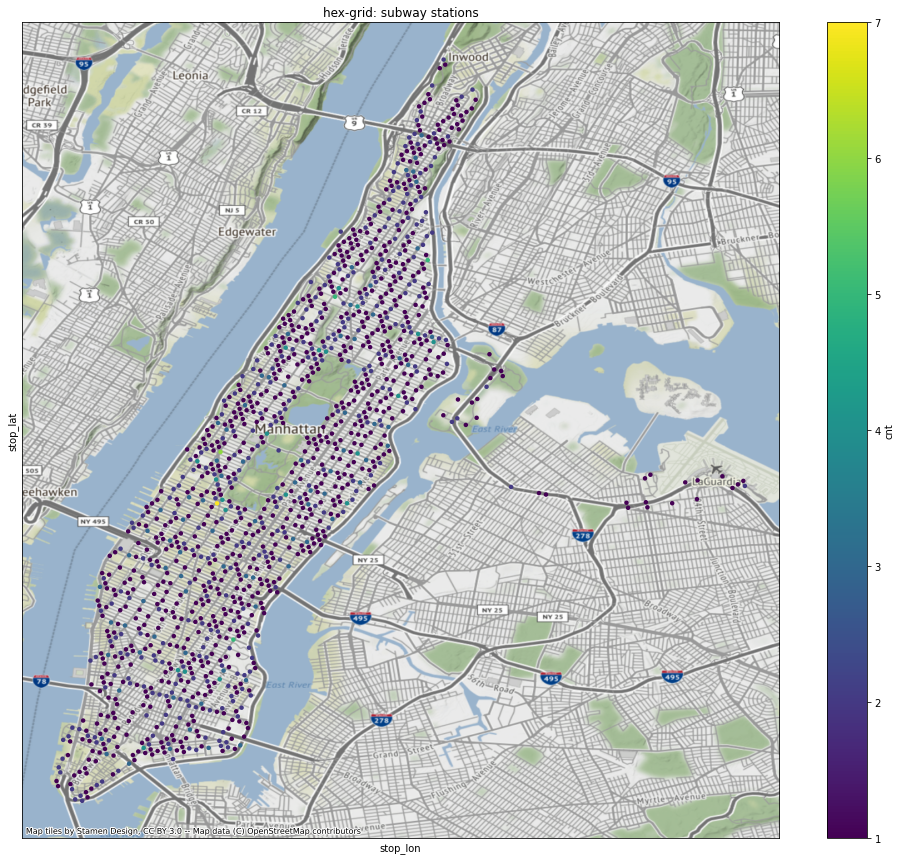

In [35]:
fig, ax = plt.subplots(1, figsize=(12, 12))

# pltot the hexs
stopsg.plot.scatter(ax=ax, x='stop_lon', y='stop_lat', c='cnt',
                    edgecolors='none', colormap='viridis', marker='o', figsize=(17,15));
plt.xticks([], []); plt.yticks([], [])

plt.title('hex-grid: subway stations');

cx.add_basemap(ax=ax, crs="EPSG:4326")


In [36]:
def kring_smoothing(df, hex_col, metric_col, k):
    dfk = df[[hex_col]] 
    dfk.index = dfk[hex_col]
    dfs =  (dfk[hex_col]
                 .apply(lambda x: pd.Series(list(h3.k_ring(x,k)))).stack()
                 .to_frame('hexk').reset_index(1, drop=True).reset_index()
                 .merge(df[[hex_col,metric_col]]).fillna(0)
                 .groupby(['hexk'])[[metric_col]].sum().divide((1 + 3 * k * (k + 1)))
                 .reset_index()
                 .rename(index=str, columns={"hexk": hex_col}))
    dfs['stop_lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['stop_lon'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfs

sum sanity check: 1.0


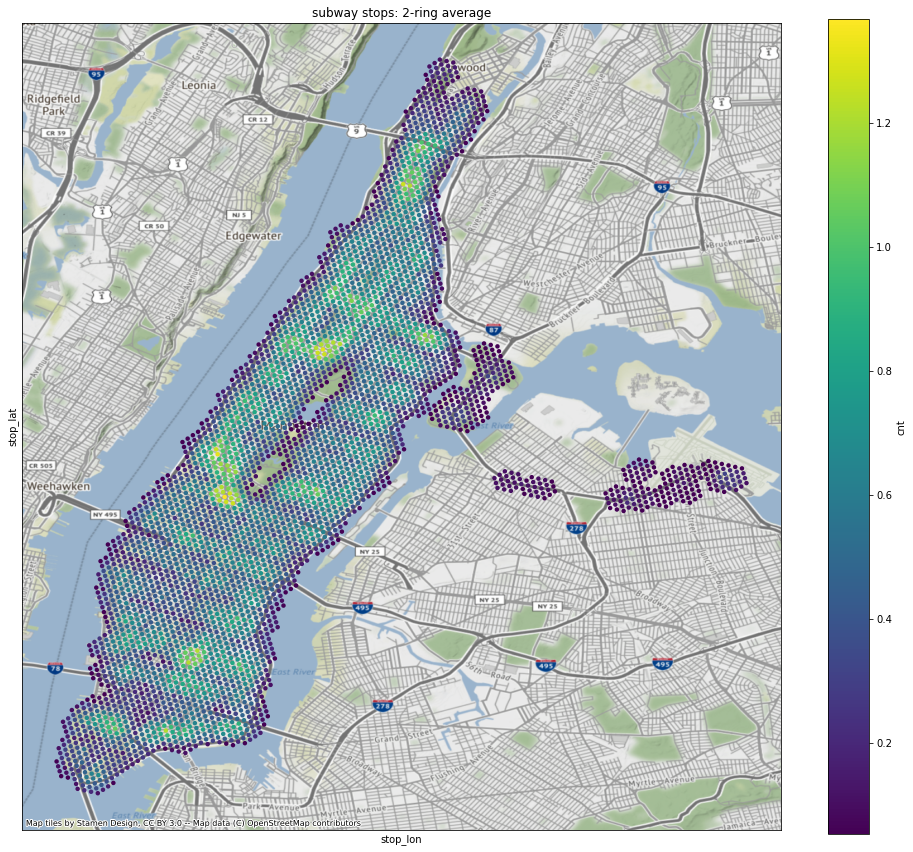

In [37]:
#kring_smoothing
k = 2
stops_kring= kring_smoothing(stopsg, hex_col, metric_col='cnt', k=k)
print('sum sanity check:', stops_kring['cnt'].sum() / stopsg['cnt'].sum())

fig, ax = plt.subplots(1, figsize=(12, 12))

# pltot the hexs
stops_kring.plot.scatter(ax=ax, x='stop_lon', y='stop_lat', c='cnt',
                    edgecolors='none', colormap='viridis', marker='o', figsize=(17,15));
plt.xticks([], []); plt.yticks([], [])
plt.title('subway stops: 2-ring average');

cx.add_basemap(ax=ax, crs="EPSG:4326")

In [33]:
stops_kring

,hex11,cnt,stop_lat,stop_lon
0,8b2a10088000fff,0.052632,40.797823,-73.974752
1,8b2a10088001fff,0.157895,40.797454,-73.974432
2,8b2a10088003fff,0.105263,40.797437,-73.975043
3,8b2a10088004fff,0.052632,40.798209,-73.974461
4,8b2a10088005fff,0.052632,40.797839,-73.974141
...,...,...,...,...
16916,8b2a1072ddb2fff,0.105263,40.716531,-73.991752
16917,8b2a1072ddb3fff,0.052632,40.716162,-73.991432
16918,8b2a1072ddb4fff,0.052632,40.716933,-73.990852
16919,8b2a1072ddb5fff,0.052632,40.716564,-73.990532


In [20]:
geo_json = feed.routes_to_geojson(include_stops=True)

/Users/petermehler/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/petermehler/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/petermehler/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/petermehler/opt/anaconda3/lib/python3.9/site-packages/pandas/core/co

In [22]:
import json
with open('manhattan_geojson.json', 'w') as f:
        json.dump(geo_json, f) 